In [46]:
from operator import add

from typing import TypedDict, Annotated

from langgraph.types import Command
from pydantic import BaseModel
from langchain.chat_models import init_chat_model

llm = init_chat_model("openai:gpt-4o")

class AnswerOutput(BaseModel):
    attempt: int
    answer: str


class FeedbackOutput(BaseModel):
    attempt: int
    feedback: str


class State(TypedDict):
    answer: str
    player_answers: Annotated[list[AnswerOutput], add]
    feedbacks: Annotated[list[FeedbackOutput], add]



In [47]:

def player(state: State) -> {"player_answers": list[AnswerOutput]}:
    player_answers = state.get("player_answers", [])
    feedbacks = state.get("feedbacks", [])

    player_llm = llm.with_structured_output(AnswerOutput)

    player_res = player_llm.invoke(
        f"""

        지금 한국어로 스무고개 게임을 하고 있습니다. 당신은 피드백을 바탕으로 정답을 맞춰야 합니다. 정답은 한국어로 한 단어 입니다.

        지금은 {len(player_answers)}째 시도 입니다.

        0번째 시도라면 아무 단어나 제시해주세요.

        이전에 상대방이 준 피드백 을 참고해서 새로운 정답을 제시해 주세요.

        이것은 그동안 답변했던 정답들입니다.
        <player_answers>
        {player_answers}
        </player_answers>

        이것은 그 정답들에 대한 피드백입니다. attempt 값을 가지고 다음 정답을 추론해 주세요.
        </feedbacks>
        {feedbacks}
        </feedbacks>

        답변할 때 이전 시도횟수에서 +1 해서 답변을 해주세요.
        """
    )
    print(f" 🔥‍ - ✅{player_res.answer}")
    return {
        "player_answers": [{"attempt": player_res.attempt, "answer": player_res.answer}],
    }


def feedback(state: State) -> {"feedbacks": list[FeedbackOutput]}:

    answer = state["answer"]
    player_answers = state.get("player_answers", [])
    feedbacks = state.get("feedbacks", [])

    feedback_llm = llm.with_structured_output(FeedbackOutput)
    feedback_res = feedback_llm.invoke(
        f"""

        지금 한국어로 스무고개 게임을 하고 있습니다, 당신은 상대방이 정답을 맞출 수 있도록 힌트를 피드백으로 돌려주어야 합니다.

        여기 정답이 있습니다.
        <answer>
        {answer}
        </answer>


        그 동안 상대방에게 주었던 피드백 목록입니다.
        <feedbacks>
        {feedbacks}
        </feedbacks>

        attempt 번호에 대한 상대방의 오답입니다.
        <player_answers>
        {player_answers}
        </player_answers>

        상대방에서 20번의 기회가 있기때문에 10번정도에 맞출 수 있도록 점차 피드백을 추상적인 수준에서 제시해 주시고, 점점 구체화 해주세요.
        피드백에 정답을 직접 언급해서는 안됩니다.

        피드백의 길이는 한 문장으로 주세요, 200글자 보다 작아야 합니다.
        시도 횟수(attempt)는 {len(player_answers)}로 되돌려 주세요.

        """
    )

    print(f" 🏃‍ - ➡️{feedback_res.feedback}")
    return Command(
        goto="player",
        update={
            "feedbacks": [{"attempt": feedback_res.attempt, "feedback": feedback_res.feedback}]
        }
    )


def gate(state: State):
    player_answers = state.get("player_answers", [])
    last_answer = player_answers[-1]
    if last_answer["answer"] == state["answer"]:
        return "sucess"
    elif last_answer["attempt"] == 20:  # 20 번째 시도에서 종료.
        return "fail"
    return "feedback"


def print_result(state: State):
    answer = state["answer"]
    player_answers = state.get("player_answers", [])
    feedbacks = state.get("feedbacks", [])

    print("==========================================")
    print(f"정답은 : {answer}")
    print("==========================================")
    for ans in player_answers:
        print(f"시도했던 정답들 :{ans["attempt"]}. {ans["answer"]}")
    print("==========================================")
    for feed in feedbacks:
        print(f"피드백들 : {feed['attempt']}. {feed['feedback']}")
    print("==========================================")

def sucess(state: State):
    print_result(state)
    print("🎉🎉🎉🎉🎉🎉🎉🎉🎉 성공!! 🎉🎉🎉🎉🎉🎉🎉🎉🎉")

def fail(state: State):
    print_result(state)
    print("😭😭😭😭😭😭😭😭😭 20번이 넘었습니다. 😭😭😭😭😭😭😭😭😭")


In [48]:
from langgraph.graph import StateGraph, START, END

graph_builder = StateGraph(State)
(
    graph_builder
    .add_node("player", player)
    .add_node("feedback", feedback, destinations={"player"})
    .add_node("sucess", sucess)
    .add_node("fail", fail)

    .add_edge(START, "player")
    .add_conditional_edges("player", gate, {
        "sucess": "sucess",
        "fail" : "fail",
        "feedback": "feedback",
    })
)

graph = graph_builder.compile()

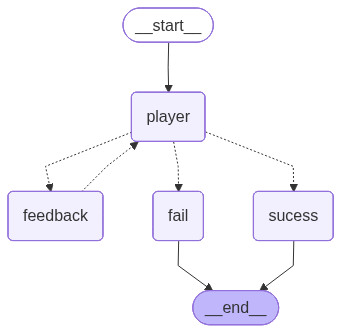

In [49]:
display(graph)

In [50]:
graph.invoke({
    "answer": "토마토"
},
    {"recursion_limit": 40}
)

 🔥‍ - ✅나무
 🏃‍ - ➡️정답은 자연에서 자라지만 나무는 아닙니다.
 🔥‍ - ✅꽃
 🏃‍ - ➡️정답은 식용 가능하고, 일반적으로 붉은색입니다.
 🔥‍ - ✅사과
 🏃‍ - ➡️정답은 과일 혹은 채소로서, 샐러드에 자주 사용됩니다.
 🔥‍ - ✅토마토
정답은 : 토마토
시도했던 정답들 :1. 나무
시도했던 정답들 :2. 꽃
시도했던 정답들 :3. 사과
시도했던 정답들 :4. 토마토
피드백들 : 1. 정답은 자연에서 자라지만 나무는 아닙니다.
피드백들 : 2. 정답은 식용 가능하고, 일반적으로 붉은색입니다.
피드백들 : 3. 정답은 과일 혹은 채소로서, 샐러드에 자주 사용됩니다.
🎉🎉🎉🎉🎉🎉🎉🎉🎉 성공!! 🎉🎉🎉🎉🎉🎉🎉🎉🎉


{'answer': '토마토',
 'player_answers': [{'attempt': 1, 'answer': '나무'},
  {'attempt': 2, 'answer': '꽃'},
  {'attempt': 3, 'answer': '사과'},
  {'attempt': 4, 'answer': '토마토'}],
 'feedbacks': [{'attempt': 1, 'feedback': '정답은 자연에서 자라지만 나무는 아닙니다.'},
  {'attempt': 2, 'feedback': '정답은 식용 가능하고, 일반적으로 붉은색입니다.'},
  {'attempt': 3, 'feedback': '정답은 과일 혹은 채소로서, 샐러드에 자주 사용됩니다.'}]}